# Dev material

In [1]:
import numpy as np
import xarray as xr
import dask.array as da
import dask.dataframe as dd

import statsmodels.api as sm

import sstats.tseries as ts

In [ ]:
from dask.distributed import Client, LocalCluster

#
cluster = LocalCluster()
#
# from dask_jobqueue import PBSCluster
# cluster = PBSCluster()
# w = cluster.scale(28*1)
#
client = Client(cluster)
client

---

## wrap statsmodel with dask

outputs a dask dataframe or an xarray

for practical reason, easier to build a dask array first which can then be converted into a dataframe or 

In [26]:
def wrapper(
    func, time, params=1, chunks=None, dtype="float", output="xarray", **kwargs
):
    """Wraps timeseries generation code in order to distribute the generation

    Parameters
    ----------
        func: method
            Method wrapped, signature needs to be func(p1, p2, ..., time, draws=1, **kwargs)
            where p1, p2 are dimensioning parameters that are nor time nor draw
            Minimal signature is func(time, draws=1, **kwargs)
        time: int, np.ndarray, tuple
            Number of time steps, time array, tuple (N, dt)
        params: int, dict, optional
            Parameters that will lead to dimensions
        chunks: dict, optional
            Associated chunks
        seed: int, optional
            numpy seed
        **kwargs:
            passed to func
    """

    if isinstance(time, int):
        time = np.arange(time)
    elif isinstance(time, tuple):
        time = np.arange(0.0, time[0]) * time[1]
    else:
        time = np.array(time)
    Nt = time.size

    if isinstance(params, dict):
        dims = {}
        for d, v in params.items():
            if d == "draw" and isinstance(v, int):
                dims[d] = np.arange(v)
            else:
                dims[d] = np.array(v, ndmin=1)
    else:
        dims = {"draw": np.array(range(params), ndmin=1)}
    dims["time"] = time
    Nd = len(dims)
    shape = tuple(v.size for d, v in dims.items())

    xr_chunks = {d: "auto" for d in dims}
    xr_chunks["time"] = -1
    if chunks:
        xr_chunks.update(**chunks)
    da_chunks = tuple(xr_chunks[d] for d in dims)

    # transform dimensions into dask arrays with appropriate forms
    dims_da = tuple(
        da.from_array(
            dims[d].reshape(tuple(dims[d].size if i == j else 1 for j in range(Nd))),
            chunks=tuple(xr_chunks[d] if i == j else -1 for j in range(Nd)),
            name=d,
        )
        for i, d in enumerate(dims)
    )

    # wraps func to reinit numpy seed from chunk number
    def _func(*args, seed=None, block_info=None, **kwargs):
        if seed is None:
            seed = np.random.randint(0, 2**32 - 1)
        np.random.seed(seed + block_info[0]["num-chunks"][0])
        return func(*args[1:], draws=args[0].shape[-2], seed=seed, **kwargs)

    x = da.empty(shape=shape, chunks=da_chunks)
    dims_da = tuple(d for d in dims_da if d.name != "draw")
    x = x.map_blocks(_func, *dims_da, **kwargs, dtype=dtype)

    x = x.squeeze()
    dims = {d: v for d, v in dims.items() if v.size > 1}

    # put result in an xarray DataArray
    if output == "xarray":
        x = xr.DataArray(x, dims=tuple(dims), coords=dims)
    elif output == "dask_dd":
        assert x.ndim < 3, (
            "Data generated is not 2D and cannot be transformed" + " into a dataframe"
        )
        to_index = lambda d: (
            dd.from_array(dims[d], columns=d).to_frame().set_index(d).index
        )
        if shape[0] == 1:
            i = to_index("time")
            c = "draw"
        else:
            i = to_index("draw")
            c = time
        x = dd.from_dask_array(x, index=i, columns=c)

    return x

---

## test with statsmodel arma

In [5]:
np.random.seed(12345)
arparams = np.array([0.75, -0.25])
maparams = np.array([0.65, 0.35])
ar = np.r_[1, -arparams]  # add zero-lag and negate
ma = np.r_[1, maparams]  # add zero-lag


def arma(time, draws=1, ar=None, ma=None, **kwargs):
    # assert False, 'draw size = {}, time size = {}'.format(draws.size, time.size)
    if not isinstance(time, int):
        time = time.size
    return sm.tsa.arma_generate_sample(ar, ma, (draws, time), axis=-1)


draws = 1000
kwargs = {"ar": ar, "ma": ma, "seed": None}


print(arma(250, ar=ar, ma=ma).shape)

x = wrapper(arma, 250, params=draws, **kwargs)
print(x)

x = wrapper(arma, 250, params={"draw": draws}, output="dask_dd", **kwargs)
print(x.compute().head())

x = wrapper(arma, 250, params=draws, output="dask_dd", **kwargs)
print(x.compute().head())

x = wrapper(arma, 250, output="dask_dd", **kwargs)
print(x.compute().head())

(1, 250)
<xarray.DataArray '_func-fa2cab234c7769042e291bf86c71dbac' (draw: 1000, time: 250)>
dask.array<_func, shape=(1000, 250), dtype=float64, chunksize=(1000, 250), chunktype=numpy.ndarray>
Coordinates:
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 242 243 244 245 246 247 248 249
           0         1         2         3         4         5         6    \
draw                                                                         
0     0.420004 -0.037290 -1.031731 -2.213792 -1.847825 -0.981964 -0.985697   
1    -1.622554 -3.063379 -2.728447 -1.433446  0.297404  1.131738  0.499690   
2    -2.378865 -2.974707 -3.662048 -3.084866 -2.569831 -2.321288 -0.572641   
3     0.339893 -0.607061 -0.949720 -1.197896 -0.651863  1.183588  2.102628   
4    -0.024574 -0.168138  1.048686  2.975190  2.832634  2.789615  0.420609   

           7         8         9    ...       240       241       242  \
draw          

In [53]:
def _exp_autocorr(tau, rms, time, draws=1, dt=None, **kwargs):
    """ """
    # time = float(time.squeeze())
    arma = sm.tsa.arma_generate_sample
    out = np.zeros((tau.size, rms.size, draws, time.size))
    for i, t in enumerate(tau[:, 0, 0, 0]):
        for j, r in enumerate(rms[0, :, 0, 0]):
            ar = np.array([1, -dt / t])  # watch for sign
            am = np.array(
                [
                    1,
                ]
            )
            # assert False, 'ar={}, am={}, t={}, r={}'.format(ar, am, t, r)
            # assert False, '{}'.format(time)
            out[i, j, :, :] = arma(
                ar,
                am,
                (draws, time.size),
                axis=-1,
                scale=np.sqrt(2 * dt / t) * r,
            )
    return out


def exp_autocorr(time, tau, rms, draws=1, **kwargs):
    """ """
    if isinstance(time, tuple):
        dt = time[1]
    else:
        dt = time[1] - time[0]

    x = wrapper(
        _exp_autocorr,
        time,
        params={"tau": tau, "rms": rms, "draw": draws},
        dt=dt,
        **kwargs
    )
    if "tau" not in x.dims:
        x = x.assign_attrs(tau=tau)
    if "rms" not in x.dims:
        x = x.assign_attrs(rms=rms)

    return x


x = exp_autocorr((100, 1 / 24), np.arange(10, 100, 10), 1, draws=10)
x

<xarray.DataArray 'getitem-bac2825e6320791554cdcd2ddc225879' (tau: 9, draw: 10, time: 100)>
dask.array<getitem, shape=(9, 10, 100), dtype=float64, chunksize=(9, 10, 100), chunktype=numpy.ndarray>
Coordinates:
  * tau      (tau) int64 10 20 30 40 50 60 70 80 90
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 4.0 4.042 4.083 4.125
Attributes:
    rms:      1

In [ ]:
# _ = x.sel(tau=50, draw=slice(1)).plot.line(x='time')

---

## test library

In [5]:
x = ts.normal(1000, params=100)  # loc=0, scale=1
y = ts.normal(1000, params=100)  # loc=0, scale=1
z = x + 1j * y

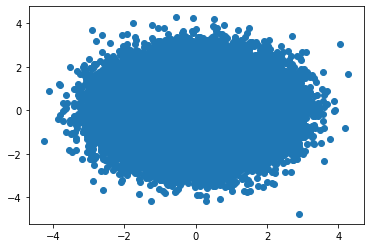

In [8]:
import matplotlib.pyplot as plt

plt.scatter(x.values, y.values)